<a href="https://colab.research.google.com/github/rjain-22/r_jain/blob/main/RohanJain_DSCI352_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import files
uploaded = files.upload()

Saving titanic.csv to titanic (1).csv


Train accuracy: 0.785064935064935
Test  accuracy: 0.7821482602118003

Train confusion matrix:
 [[1020   23]
 [ 308  189]]

Test  confusion matrix:
 [[433  14]
 [130  84]]


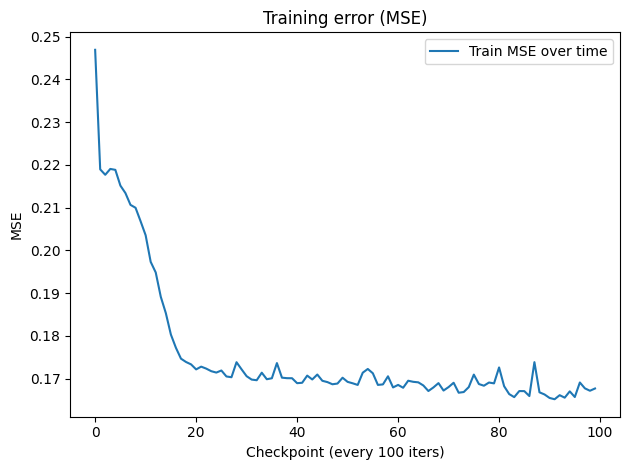

In [8]:
# Prepare a dataset for part a
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("titanic.csv")

# normalize headers
df.columns = [c.strip().lower() for c in df.columns]

# keep columns
required = ["passenger", "class", "sex", "age", "survived"]
missing = [c for c in required if c not in df.columns]
if missing:
    print("Available columns:", list(df.columns))
    raise KeyError(f"Missing required columns: {missing}")
df = df[required].copy()

# clean strings
for c in ["class", "sex", "age", "survived"]:
    df[c] = df[c].astype(str).str.strip().str.lower()

# map categories -> numbers
class_map = {"1st": 1, "2nd": 2, "3rd": 3, "crew": 0}
sex_map   = {"female": 0, "male": 1}
age_map   = {"child": 0, "adult": 1}
surv_map  = {"no": 0, "yes": 1}

df["class"]    = df["class"].map(class_map)
df["sex"]      = df["sex"].map(sex_map)
df["age"]      = df["age"].map(age_map)
df["survived"] = df["survived"].map(surv_map)

# drop rows with unknown categories
df = df.dropna(subset=["class", "sex", "age", "survived"])

# build features/target
y = df["survived"].astype(int).values
X = df[["class", "sex", "age"]].astype(float).values  # 'passenger' is an ID, not a feature

# scale features (helps this tiny NN)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.30, random_state=2023, stratify=y
)

# partial credit for this class (with modifications): https://realpython.com/python-ai-neural-network/, by Déborah Mesquita

import matplotlib.pyplot as plt

class TwoNodeNN:
    def __init__(self, learning_rate, n_features):
        self.W1 = np.random.randn(2, n_features) * 0.01
        self.b1 = np.zeros(2)
        self.W2 = np.random.randn(1, 2) * 0.01
        self.b2 = 0.0
        self.learning_rate = learning_rate

    def _sigmoid(self, x):
        x = np.clip(x, -50, 50)
        return 1.0 / (1.0 + np.exp(-x))

    def _sigmoid_deriv_from_sigmoid(self, s):
        return s * (1.0 - s)

    # -------- forward pass --------
    def _forward_single(self, x):
        z1 = self.W1 @ x + self.b1
        a1 = self._sigmoid(z1)
        z2 = self.W2 @ a1 + self.b2
        yhat = self._sigmoid(z2)[0]
        return z1, a1, z2.item(), yhat

    # Vectorized predict_proba for grid/batches
    def predict_proba(self, X):
        if hasattr(X, "values"):
            X = X.values
        X = np.asarray(X, dtype=float)
        if X.ndim == 1:
            _, a1, _, yhat = self._forward_single(X)
            return yhat
        else:
            # Vectorized forward
            # Z1 = X @ W1.T + b1 -> (n,2)
            Z1 = X @ self.W1.T + self.b1
            A1 = self._sigmoid(Z1)
            Z2 = A1 @ self.W2.T + self.b2
            Yhat = self._sigmoid(Z2).reshape(-1)
            return Yhat

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

    # -------- backprop (MSE) for one sample --------
    def _compute_gradients(self, x, y):
        z1, a1, z2, yhat = self._forward_single(x)

        # Loss L = (yhat - y)^2
        dL_dyhat = 2.0 * (yhat - y)
        dyhat_dz2 = yhat * (1.0 - yhat)
        # More stable: use yhat directly:
        delta2 = dL_dyhat * dyhat_dz2

        # Output layer grads
        dL_dW2 = delta2 * a1.reshape(1, -1)
        dL_db2 = delta2

        # Backprop to hidden
        # delta1 = (W2^T * delta2) ⊙ sigmoid'(z1)
        sigp_z1 = self._sigmoid_deriv_from_sigmoid(a1)
        delta1 = (self.W2.T.reshape(2,) * delta2) * sigp_z1

        # Hidden layer grads
        dL_dW1 = delta1.reshape(-1, 1) @ x.reshape(1, -1)
        dL_db1 = delta1
        return dL_dW1, dL_db1, dL_dW2, dL_db2

    def _update(self, dW1, db1, dW2, db2):
        lr = self.learning_rate
        self.W1 -= lr * dW1
        self.b1 -= lr * db1
        self.W2 -= lr * dW2
        self.b2 -= lr * db2

    def train(self, X, y, iterations=20000, report_every=200):
        errs = []
        n = len(y)
        for it in range(iterations):
            i = np.random.randint(n)
            dW1, db1, dW2, db2 = self._compute_gradients(X[i], y[i])
            self._update(dW1, db1, dW2, db2)
            if it % report_every == 0:
                yhat_all = self.predict_proba(X)
                errs.append(np.mean((yhat_all - y) ** 2))
        return errs

# Plot the results
learning_rate = 0.1
nn = TwoNodeNN(learning_rate, n_features=X_train.shape[1])

training_error = nn.train(X_train, Y_train, iterations=10000, report_every=100)

# Evaluate
yhat_train_p = nn.predict_proba(X_train)
yhat_test_p  = nn.predict_proba(X_test)

yhat_train = (yhat_train_p >= 0.5).astype(int)
yhat_test  = (yhat_test_p  >= 0.5).astype(int)

print("Train accuracy:", accuracy_score(Y_train, yhat_train))
print("Test  accuracy:", accuracy_score(Y_test,  yhat_test))
print("\nTrain confusion matrix:\n", confusion_matrix(Y_train, yhat_train))
print("\nTest  confusion matrix:\n",  confusion_matrix(Y_test,  yhat_test))

# Error plot
plt.figure()
plt.plot(training_error, label="Train MSE over time")
plt.title("Training error (MSE)")
plt.xlabel("Checkpoint (every 100 iters)")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.savefig("cumulative_error.png")
plt.show()


Train accuracy: 0.6772727272727272
Test  accuracy: 0.6762481089258698

Train confusion matrix:
 [[1043    0]
 [ 497    0]]

Test  confusion matrix:
 [[447   0]
 [214   0]]


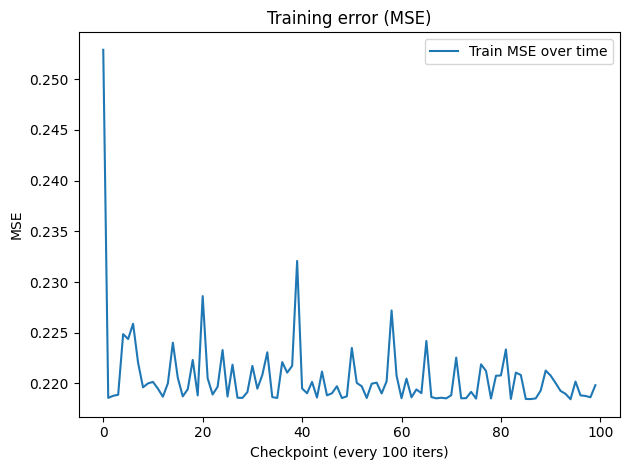

In [9]:
# Prepare a dataset for part b -- bonus
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("titanic.csv")

# normalize headers
df.columns = [c.strip().lower() for c in df.columns]

# keep columns
required = ["passenger", "class", "sex", "age", "survived"]
missing = [c for c in required if c not in df.columns]
if missing:
    print("Available columns:", list(df.columns))
    raise KeyError(f"Missing required columns: {missing}")
df = df[required].copy()

# clean strings
for c in ["class", "sex", "age", "survived"]:
    df[c] = df[c].astype(str).str.strip().str.lower()

# map categories -> numbers
class_map = {"1st": 1, "2nd": 2, "3rd": 3, "crew": 0}
sex_map   = {"female": 0, "male": 1}
age_map   = {"child": 0, "adult": 1}
surv_map  = {"no": 0, "yes": 1}

df["class"]    = df["class"].map(class_map)
df["sex"]      = df["sex"].map(sex_map)
df["age"]      = df["age"].map(age_map)
df["survived"] = df["survived"].map(surv_map)

# drop rows with unknown categories
df = df.dropna(subset=["class", "sex", "age", "survived"])

# build features/target
y = df["survived"].astype(int).values
X = df[["class", "sex", "age"]].astype(float).values  # 'passenger' is an ID, not a feature

# scale features (helps this tiny NN)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.30, random_state=2023, stratify=y
)

# partial credit for this class (with modifications): https://realpython.com/python-ai-neural-network/, by Déborah Mesquita

import matplotlib.pyplot as plt

# 2 hidden layers, 2 neurons each

import numpy as np

class TwoHidden2x2NN:
    def __init__(self, learning_rate, n_features):
        # Layer 1 (input -> hidden1, 2 units)
        self.W1 = np.random.randn(2, n_features) * 0.01
        self.b1 = np.zeros(2)

        # Layer 2 (hidden1 -> hidden2, 2 units)
        self.W2 = np.random.randn(2, 2) * 0.01
        self.b2 = np.zeros(2)

        # Output (hidden2 -> 1 output)
        self.W3 = np.random.randn(1, 2) * 0.01
        self.b3 = 0.0

        self.learning_rate = learning_rate

    def _sigmoid(self, x):
        x = np.clip(x, -50, 50)
        return 1.0 / (1.0 + np.exp(-x))

    def _sigmoid_deriv_from_sigmoid(self, s):
        # if s = sigmoid(z)
        return s * (1.0 - s)

    # forward (single sample)
    def _forward_single(self, x):
        # x: (d,)
        z1 = self.W1 @ x + self.b1
        a1 = self._sigmoid(z1)

        z2 = self.W2 @ a1 + self.b2
        a2 = self._sigmoid(z2)

        z3 = self.W3 @ a2 + self.b3
        yhat = self._sigmoid(z3)[0]

        return z1, a1, z2, a2, z3.item(), yhat

    # vectorized predict_proba
    def predict_proba(self, X):
        if hasattr(X, "values"):
            X = X.values
        X = np.asarray(X, dtype=float)

        if X.ndim == 1:
            *_ , yhat = self._forward_single(X)
            return yhat
        else:
            # X: (n, d)
            Z1 = X @ self.W1.T + self.b1
            A1 = self._sigmoid(Z1)

            Z2 = A1 @ self.W2.T + self.b2
            A2 = self._sigmoid(Z2)

            Z3 = A2 @ self.W3.T + self.b3
            Yhat = self._sigmoid(Z3).reshape(-1)
            return Yhat

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

    # backprop (MSE) for one sample
    def _compute_gradients(self, x, y):
        # Forward
        z1, a1, z2, a2, z3, yhat = self._forward_single(x)

        # Loss L = (yhat - y)^2
        dL_dyhat = 2.0 * (yhat - y)
        dyhat_dz3 = yhat * (1.0 - yhat)
        delta3 = dL_dyhat * dyhat_dz3

        # Output layer grads
        dL_dW3 = delta3 * a2.reshape(1, -1)
        dL_db3 = delta3

        # Backprop to hidden2
        sigp_z2 = self._sigmoid_deriv_from_sigmoid(a2)
        delta2 = (self.W3.T.reshape(2,) * delta3) * sigp_z2

        dL_dW2 = delta2.reshape(-1, 1) @ a1.reshape(1, -1)
        dL_db2 = delta2

        # Backprop to hidden1
        sigp_z1 = self._sigmoid_deriv_from_sigmoid(a1)
        delta1_linear = self.W2.T @ delta2
        delta1 = delta1_linear * sigp_z1

        dL_dW1 = delta1.reshape(-1, 1) @ x.reshape(1, -1)
        dL_db1 = delta1
        return dL_dW1, dL_db1, dL_dW2, dL_db2, dL_dW3, dL_db3

    def _update(self, dW1, db1, dW2, db2, dW3, db3):
        lr = self.learning_rate
        self.W1 -= lr * dW1
        self.b1 -= lr * db1
        self.W2 -= lr * dW2
        self.b2 -= lr * db2
        self.W3 -= lr * dW3
        self.b3 -= lr * db3

    def train(self, X, y, iterations=20000, report_every=200):
        errs = []
        n = len(y)
        for it in range(iterations):
            i = np.random.randint(n)
            grads = self._compute_gradients(X[i], y[i])
            self._update(*grads)
            if it % report_every == 0:
                yhat_all = self.predict_proba(X)
                errs.append(np.mean((yhat_all - y) ** 2))
        return errs

# Plot the results
learning_rate = 0.1
nn = TwoHidden2x2NN(learning_rate, n_features=X_train.shape[1])

training_error = nn.train(X_train, Y_train, iterations=10000, report_every=100)

# Evaluate
yhat_train_p = nn.predict_proba(X_train)
yhat_test_p  = nn.predict_proba(X_test)

yhat_train = (yhat_train_p >= 0.5).astype(int)
yhat_test  = (yhat_test_p  >= 0.5).astype(int)

print("Train accuracy:", accuracy_score(Y_train, yhat_train))
print("Test  accuracy:", accuracy_score(Y_test,  yhat_test))
print("\nTrain confusion matrix:\n", confusion_matrix(Y_train, yhat_train))
print("\nTest  confusion matrix:\n",  confusion_matrix(Y_test,  yhat_test))

# Error plot
plt.figure()
plt.plot(training_error, label="Train MSE over time")
plt.title("Training error (MSE)")
plt.xlabel("Checkpoint (every 100 iters)")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.savefig("cumulative_error.png")
plt.show()